# Merge the prophage predictions with RAST metadata

Combine RAST metadata and prophage predictions

In [1]:
import os
import sys
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import pandas as pd
import seaborn as sns
import numpy as np

import math
import re

from PhiSpyAnalysis import theils_u, DateConverter, printmd
from PhiSpyAnalysis import read_phages, read_gtdb, read_checkv, read_base_pp, read_categories, read_metadata

from scipy.stats import pearsonr, f_oneway
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, LeaveOneGroupOut
from sklearn import metrics

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd, tukeyhsd, MultiComparison
from statsmodels.multivariate.manova import MANOVA
from sklearn import decomposition
from sklearn.ensemble import RandomForestClassifier

# for parsing collection dates
from dateutil.parser import parse, ParserError
import pytz

import subprocess
import gzip


# Read the phage data. Check the version!

We have two data sets: `small` is just 99 genomes and 1,561 phages and should run quickly for development. `not small` is all the data!

In [2]:
use_small_data=False
phagesdf = read_phages(use_small_data=use_small_data)

Please note that this was run with git commit 1a2a28b that has 567,404 genomes parsed.
Initially there were 3,265,453 kept phages, but after filtering we kept 1,961,109 prophages from 388,797 genomes

In [3]:
phagesdf

,assembly_accession,assembly_name,Genome length,Contigs,Phage Contigs,Total Predicted Prophages,Kept,No phage genes,Not enough genes,bp prophage
0,GCA_000043285.1,ASM4328v1,705557.0,1.0,1.0,2.0,0.0,2.0,0.0,0.0
1,GCA_000046685.1,ASM4668v1,1581384.0,1.0,1.0,18.0,3.0,0.0,15.0,97011.0
2,GCA_000046705.1,ASM4670v1,1931047.0,1.0,1.0,36.0,7.0,0.0,29.0,278490.0
3,GCA_000046845.1,ASM4684v1,3598621.0,1.0,1.0,13.0,3.0,4.0,6.0,83112.0
4,GCA_000047365.1,ASM4736v1,4840898.0,3.0,3.0,22.0,3.0,3.0,16.0,213427.0
...,...,...,...,...,...,...,...,...,...,...
567399,GCA_905187425.1,Xanthomonas_sp._CPBF_424_-_hybrid_assembly,4900930.0,1.0,1.0,46.0,7.0,9.0,30.0,214278.0
567400,GCA_905188235.1,ASM90518823v1,4963609.0,1.0,1.0,29.0,4.0,4.0,21.0,178993.0
567401,GCA_905219375.1,QI0054,3034314.0,1.0,1.0,12.0,4.0,3.0,5.0,178527.0
567402,GCA_905219385.1,QI0055,3034113.0,1.0,1.0,12.0,4.0,3.0,5.0,178526.0


### Read the data file

The metadata is from PATRIC. The phage data is from us.

**NOTE:** Some of the PATRIC data refers to specific chromosomes/fragments in the GenBank file (e.g. plasmid, chromosome), but that may not equate to our predictions, because we have used the whole GenBank file. The PATRIC metadata is redundant for many fields, and so we just keep the first entry for each NCBI Assembly.

In [4]:
metadf = read_metadata(use_small_data=use_small_data)

In [5]:
str(dict(metadf.dtypes)).replace("dtype(", "").replace("),", ",").replace("'O'", "'str'")

"{'assembly_accession': 'str', 'genome_id': 'float64', 'genome_name': 'str', 'organism_name': 'str', 'taxon_id': 'int64', 'genome_status': 'str', 'strain': 'str', 'serovar': 'str', 'biovar': 'str', 'pathovar': 'str', 'mlst': 'str', 'other_typing': 'str', 'culture_collection': 'str', 'type_strain': 'str', 'completion_date': 'str', 'publication': 'str', 'bioproject_accession': 'str', 'biosample_accession': 'str', 'genbank_accessions': 'str', 'refseq_accessions': 'str', 'sequencing_centers': 'str', 'sequencing_status': 'str', 'sequencing_platform': 'str', 'sequencing_depth': 'str', 'assembly_method': 'str', 'chromosomes': 'float64', 'plasmids': 'float64', 'contigs': 'float64', 'sequences': 'float64', 'genome_length': 'float64', 'gc_content': 'float64', 'patric_cds': 'float64', 'brc1_cds': 'float64', 'refseq_cds': 'float64', 'isolation_site': 'str', 'isolation_source': 'str', 'isolation_comments': 'str', 'collection_date': 'str', 'isolation_country': 'str', 'geographic_location': 'str', 'l

# Categorical Correlations

Are any of our categories correlated? This uses Theil's Uncertainty to measure the correlation between the categories.

In [6]:
acccol = 'assembly_accession'
interesting_cols = [acccol, 'isolation_site', 'geographic_location', 'isolation_country', 'latitude', 'longitude', 'altitude', 'depth',
                    'other_environmental', 'host_name', 'host_gender', 'host_age', 'host_health', 
                    'body_sample_site', 'body_sample_subsite', 'other_clinical', 'gram_stain', 'cell_shape',
                    'motility', 'sporulation', 'temperature_range', 'optimal_temperature', 'salinity',
                    'oxygen_requirement', 'habitat', 'disease', 'isolation_date']

hmi = pd.DataFrame(index=interesting_cols, columns=interesting_cols, dtype=float)
for i,j in enumerate(interesting_cols):
    for x,y in enumerate(interesting_cols):
        hmi.iloc[i,x] = theils_u(metadf.loc[:,j], metadf.loc[:,y])

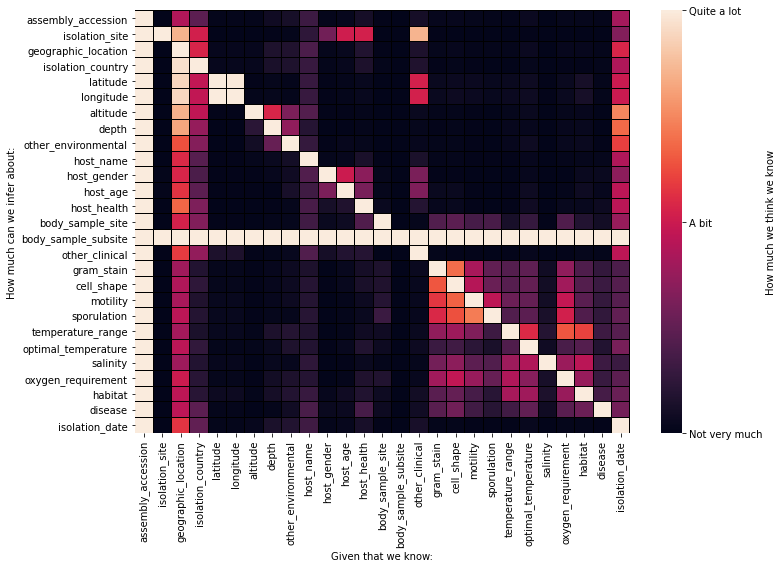

In [7]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(11, 8))
# sns.heatmap(hmi, cmap='Blues', ax=ax)
ax = sns.heatmap(hmi, linecolor='k', linewidths=0.01, ax=ax, cbar_kws={'label': 'How much we think we know'})
t = ax.set_ylabel("How much can we infer about:")
t = ax.set_xlabel("Given that we know:")
cbar = ax.collections[0].colorbar
cbar.set_ticks([0, .5, 1])
cbar.set_ticklabels(['Not very much', 'A bit', 'Quite a lot'])
plt.tight_layout()

fig.savefig(f"images/categeorical_heatmap.png")
fig.savefig(f"images/categeorical_heatmap.svg")

In [8]:
printmd(f"**Fig. S\*\***. Conditional categorical correlations of variables. Theil's Uncertainty was used to compare the correlations between variables. The colour in each cell represents the relationship between the category along the x-axis and the category along the y-axis. Thus knowing each category on the x-axis provides different information about categories on the y-axis. Note that _body_sample_subsite_ is always NULL and thus everything can predict that. There is a relationship between the geographic categories (_geographic location_, _isolation country_, _latitude_, _longitude_, _altitude_, and _depth_)")

<span style='color:black'>**Fig. S\*\***. Conditional categorical correlations of variables. Theil's Uncertainty was used to compare the correlations between variables. The colour in each cell represents the relationship between the category along the x-axis and the category along the y-axis. Thus knowing each category on the x-axis provides different information about categories on the y-axis. Note that _body_sample_subsite_ is always NULL and thus everything can predict that. There is a relationship between the geographic categories (_geographic location_, _isolation country_, _latitude_, _longitude_, _altitude_, and _depth_)</span>

###### This is hard to understand!

I know, its a conditional probability. Here are two examples to help

In [9]:
col1 = 'other_clinical'
col2 = 'isolation_site'
u1 = theils_u(metadf.loc[:,col1], metadf.loc[:,col2])
u2 = theils_u(metadf.loc[:,col2], metadf.loc[:,col1])

print(f"{col1} vs {col2} {u1}")
print(f"{col2} vs {col1} {u2}")

if u1 > u2:
    print("Theils U is probability of X given Y")
    print(f"This means that knowing the {col2} we have a lot of information about the {col1} ")
    print(f"but knowing the {col1} does not inform us about the {col2}")
else:
    print("Theils U is probability of X given Y")
    print(f"This means that knowing the {col1} we have a lot of information about the {col2} ")
    print(f"but knowing the {col2} does not inform us about the {col1}")

printmd("For example, lets look at the data for Sputum. Does it predict _other\_clinical_?")
print(metadf[metadf['isolation_site'] == 'Sputum'].groupby(['other_clinical', 'isolation_site']).size().reset_index(name='Count'))

other_clinical vs isolation_site 0.005078095497709224
isolation_site vs other_clinical 0.8588933773243432
Theils U is probability of X given Y
This means that knowing the other_clinical we have a lot of information about the isolation_site 
but knowing the isolation_site does not inform us about the other_clinical


<span style='color:black'>For example, lets look at the data for Sputum. Does it predict _other\_clinical_?</span>

                                      other_clinical isolation_site  Count
0      comorbidity:HIV negative;treatment course:adm         Sputum     39
1      comorbidity:HIV positive;treatment course:adm         Sputum     15
2  comorbidity:MDR-TB, HIV negative;treatment cou...         Sputum     25
3  comorbidity:MDR-TB, HIV positive;treatment cou...         Sputum      2
4  comorbidity:MDR_TB, HIV negative;treatment cou...         Sputum      1
5                          hospital location:non-ICU         Sputum      1
6                               treatment course:adm         Sputum      1


#### Example 2: geographic location vs. isolation country

In [10]:
col1 = 'geographic_location'
col2 = 'isolation_country'
counts12 = {}
counts21 = {}
for index, row in metadf.iterrows():
    gl = row[col1]
    ic = row[col2]
    
    if gl not in counts12:
        counts12[gl] = {}
    counts12[gl][ic] = counts12[gl].get(ic, 0) + 1
    
    if ic not in counts21:
        counts21[ic] = {}
    counts21[ic][gl] = counts21[ic].get(gl, 0) + 1

c12s = 0
c12m = 0
c21s = 0
c21m = 0
for k in counts12:
    if len(counts12[k]) == 1:
        c12s += 1
    else:
        c12m += 1

for k in counts21:
    if len(counts21[k]) == 1:
        c21s += 1
    else:
        c21m += 1

print(f"Given {len(counts12.keys()):,} {col1} you will have {c12s:,} ({c12s/len(counts12.keys())*100:.2f} %) single {col2}")
print(f"Given {len(counts12.keys()):,} {col1} you will have {c12m:,} ({c12m/len(counts12.keys())*100:.2f} %) multiple {col2}")
print(f"\nGiven {len(counts21.keys()):,} {col2} you will have {c21s:,} ({c21s/len(counts21.keys())*100:.2f} %) single {col1}")
print(f"Given {len(counts21.keys()):,} {col2} you will have {c21m:,} ({c21m/len(counts21.keys())*100:.2f} %) multiple {col1}")

Given 13,967 geographic_location you will have 13,817 (98.93 %) single isolation_country
Given 13,967 geographic_location you will have 150 (1.07 %) multiple isolation_country

Given 281 isolation_country you will have 77 (27.40 %) single geographic_location
Given 281 isolation_country you will have 204 (72.60 %) multiple geographic_location


#### Drop Geographic Location

This is just a proxy for `isolation_country` and we don't want it duplicated.

In [11]:
metadf = metadf.drop('geographic_location', axis=1)

## Read our categories

This is the data from Laura

In [12]:
catdf = read_categories()
catdf

,assembly_accession,Category,Biome
0,GCA_000003645.1,food,Terrestrial
1,GCA_000003925.1,soil,Terrestrial
2,GCA_000003955.1,human blood,Host-Associated
3,GCA_000005825.2,soil,Terrestrial
4,GCA_000006155.2,human other,Host-Associated
...,...,...,...
54640,GCA_902860175.1,built environment,Terrestrial
54641,GCA_902860185.1,human other,Host-Associated
54642,GCA_902860195.1,human other,Host-Associated
54643,GCA_902860235.1,plant,Terrestrial


### Make sure we have the right column

PATRIC calls the column `assembly_accession` while GTDB calls it `ncbi_genbank_assembly_accession`

In [13]:
acccol = 'assembly_accession'
metadf[acccol]

0         GCA_000003135.1
1         GCA_000003215.1
2         GCA_000003645.1
3         GCA_000003925.1
4         GCA_000003955.1
               ...       
320171    GCF_900167595.1
320172    GCF_900167605.1
320173    GCF_900167615.1
320174    GCF_900167625.1
320175    GCF_900167635.1
Name: assembly_accession, Length: 320176, dtype: object

In [14]:
catdf[acccol]

0           GCA_000003645.1
1           GCA_000003925.1
2           GCA_000003955.1
3           GCA_000005825.2
4           GCA_000006155.2
                ...        
54640       GCA_902860175.1
54641       GCA_902860185.1
54642       GCA_902860195.1
54643       GCA_902860235.1
54644    assembly_accession
Name: assembly_accession, Length: 54645, dtype: object

### Merge the dataframes

First, select some columns we want to keep from PATRIC, and then merge the data frames. We write this to a tsv file for Laura to append isolation information to.

In [15]:
interesting_cols = [acccol, 'isolation_site', 'isolation_country', 'latitude', 'longitude', 'altitude', 'depth',
                    'other_environmental', 'host_name', 'host_gender', 'host_age', 'host_health', 
                    'body_sample_site', 'body_sample_subsite', 'other_clinical', 'gram_stain', 'cell_shape',
                    'motility', 'sporulation', 'temperature_range', 'optimal_temperature', 'salinity',
                    'oxygen_requirement', 'habitat', 'disease', 'isolation_date']

few_interesting_cols = [acccol,  'isolation_country',  'gram_stain',  
                    'motility', 'sporulation', 'temperature_range', 'habitat', 'disease', 'isolation_date']


tempdf = metadf[interesting_cols]
# tempdf = metadf[few_interesting_cols]
temp1 = pd.merge(tempdf, catdf, how='left', left_on=acccol, right_on=acccol)
# phagemeta = pd.merge(tempdf, phagesdf, how='inner', left_on=acccol, right_on=acccol)
# phagemeta.to_csv(os.path.join('results', 'example_isolations.tsv'), sep='\t')

phagemeta = pd.merge(temp1, phagesdf, how='right', left_on=acccol, right_on=acccol)
phagemeta = phagemeta.dropna(subset=['Kept'])
phagemeta

,assembly_accession,isolation_site,isolation_country,latitude,longitude,altitude,depth,other_environmental,host_name,host_gender,...,Biome,assembly_name,Genome length,Contigs,Phage Contigs,Total Predicted Prophages,Kept,No phage genes,Not enough genes,bp prophage
0,GCA_000043285.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,ASM4328v1,705557.0,1.0,1.0,2.0,0.0,2.0,0.0,0.0
1,GCA_000046685.1,NaN,France,NaN,NaN,NaN,NaN,NaN,"Human, Homo sapiens",NaN,...,Host-Associated,ASM4668v1,1581384.0,1.0,1.0,18.0,3.0,0.0,15.0,97011.0
2,GCA_000046705.1,NaN,United States,NaN,NaN,NaN,NaN,NaN,"Human, Homo sapiens",NaN,...,Host-Associated,ASM4670v1,1931047.0,1.0,1.0,36.0,7.0,0.0,29.0,278490.0
3,GCA_000046845.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Terrestrial,ASM4684v1,3598621.0,1.0,1.0,13.0,3.0,4.0,6.0,83112.0
4,GCA_000047365.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Human, Homo sapiens",NaN,...,Host-Associated,ASM4736v1,4840898.0,3.0,3.0,22.0,3.0,3.0,16.0,213427.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
388792,GCA_905187425.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,Xanthomonas_sp._CPBF_424_-_hybrid_assembly,4900930.0,1.0,1.0,46.0,7.0,9.0,30.0,214278.0
388793,GCA_905188235.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,ASM90518823v1,4963609.0,1.0,1.0,29.0,4.0,4.0,21.0,178993.0
388794,GCA_905219375.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Homo sapiens,NaN,...,NaN,QI0054,3034314.0,1.0,1.0,12.0,4.0,3.0,5.0,178527.0
388795,GCA_905219385.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,QI0055,NaN,...,NaN,QI0055,3034113.0,1.0,1.0,12.0,4.0,3.0,5.0,178526.0


# Define the columns

These are for the columns we are going to use

In [16]:
begdata = 1 # ignore the first column which is the assembly name
# enddata = 9 # this is if we are using a smaller dataset
enddata = 28 # this is all the metadata
phagemeta.iloc[:,begdata:enddata]

,isolation_site,isolation_country,latitude,longitude,altitude,depth,other_environmental,host_name,host_gender,host_age,...,sporulation,temperature_range,optimal_temperature,salinity,oxygen_requirement,habitat,disease,isolation_date,Category,Biome
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,Mesophilic,-,NaN,NaN,Specialized,NaN,NaN,NaN,NaN
1,NaN,France,NaN,NaN,NaN,NaN,NaN,"Human, Homo sapiens",NaN,NaN,...,No,Mesophilic,37,NaN,Aerobic,Host-associated,Bacillary angiomatosis;Trench fever,1993.323066,human blood,Host-Associated
2,NaN,United States,NaN,NaN,NaN,NaN,NaN,"Human, Homo sapiens",NaN,NaN,...,No,Mesophilic,37,NaN,Aerobic,Host-associated,Bacillary angiomatosis;Cat scratch fever,NaN,human blood,Host-Associated
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,No,Mesophilic,37,Non-halophilic,Aerobic,Multiple,NaN,1957.958248,soil,Terrestrial
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Human, Homo sapiens",NaN,NaN,...,NaN,Mesophilic,28-30,NaN,Facultative,Multiple,Gastroenteritis,NaN,human other,Host-Associated
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
388792,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
388793,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
388794,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Homo sapiens,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015.915811,NaN,NaN
388795,NaN,NaN,NaN,NaN,NaN,NaN,NaN,QI0055,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015.154689,NaN,NaN


## How many NaNs are there?

In [17]:
for c in phagemeta.iloc[:,begdata:enddata].columns:
    print(f"{c}\t{phagemeta[phagemeta[c].notnull()].shape[0]}")

isolation_site	128
isolation_country	67172
latitude	2858
longitude	2856
altitude	516
depth	5661
other_environmental	5265
host_name	42112
host_gender	3042
host_age	2834
host_health	7440
body_sample_site	1554
body_sample_subsite	0
other_clinical	9046
gram_stain	7143
cell_shape	6568
motility	4701
sporulation	3557
temperature_range	3118
optimal_temperature	7458
salinity	552
oxygen_requirement	5464
habitat	3362
disease	1783
isolation_date	63822
Category	35048
Biome	35048


## Encode the data

This converts every column into categories so we can (hopefully) use it in the RF models

In [18]:
pmenc = pd.DataFrame()
for c in phagemeta.iloc[:,begdata:enddata].columns:
    pmenc[c] = phagemeta[c].astype('category').cat.codes
pmenc['isolation_date'] = phagemeta['isolation_date'].fillna(-1)
pmenc.sort_values('isolation_date')

,isolation_site,isolation_country,latitude,longitude,altitude,depth,other_environmental,host_name,host_gender,host_age,...,sporulation,temperature_range,optimal_temperature,salinity,oxygen_requirement,habitat,disease,isolation_date,Category,Biome
0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,6,1,-1,-1,32,-1,-1.000000,-1,-1
246715,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1.000000,-1,-1
246714,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1.000000,-1,-1
246713,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1.000000,-1,-1
246712,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1.000000,-1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355335,-1,-1,-1,-1,-1,-1,-1,861,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,2020.860370,-1,-1
352810,-1,32,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,2020.874059,-1,-1
355354,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,2021.005476,-1,-1
354358,-1,37,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,2021.027379,-1,-1


## Random Forest

Can we identify which features best predict the number of phages predicted. Note we should compare total/kept/etc

First, an RF with all the data. You might want to skip this!

In [19]:
x_train, x_test, y_train, y_test = train_test_split(pmenc, phagemeta.Kept.values.ravel())
clf = RandomForestClassifier(random_state=42, n_estimators=1000, bootstrap=True, n_jobs=-1, oob_score=True)
rf = clf.fit(x_train, y_train)
rf

RandomForestClassifier(n_estimators=1000, n_jobs=-1, oob_score=True,
                       random_state=42)

In [20]:
y_pred=clf.predict(x_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
f1base = metrics.f1_score(y_test, y_pred, average='weighted')
print("f1: ", f1base)

Accuracy: 0.16462962962962963
f1:  0.107041083518483


In [21]:
print(f"The boostrap choose {x_train.shape[0]:,} samples at random from {pmenc['isolation_site'].shape[0]:,} samples total")

The boostrap choose 291,597 samples at random from 388,797 samples total


## Important features

What are the most important features for predicting the number of prophages in a genome?

In [22]:
fi = pd.DataFrame(zip(pmenc.columns, rf.feature_importances_), columns=['feature', 'importance'])
impdf = fi.sort_values('importance', ascending=False)
# impdf['Number Not Null'] = phagemeta[phagemeta[impdf['feature']].notnull()].shape[0]
impdf

,feature,importance
24,isolation_date,0.391553
1,isolation_country,0.159074
7,host_name,0.083442
25,Category,0.073287
10,host_health,0.041232
13,other_clinical,0.034723
5,depth,0.027656
26,Biome,0.023787
19,optimal_temperature,0.021811
6,other_environmental,0.021500


In [23]:
def number_not_null(x):
    return phagemeta[phagemeta[x.feature].notnull()].shape[0]

def no_undl(x):
    return x.replace('_', ' ')

fi = pd.DataFrame(zip(pmenc.columns, rf.feature_importances_), columns=['feature', 'importance'])
impdf = fi.sort_values('importance', ascending=False)
impdf["Number of observations"] = impdf.apply(number_not_null, axis=1)
impdf['feature_nu'] = impdf['feature'].apply(no_undl)
impdf

,feature,importance,Number of observations,feature_nu
24,isolation_date,0.391553,63822,isolation date
1,isolation_country,0.159074,67172,isolation country
7,host_name,0.083442,42112,host name
25,Category,0.073287,35048,Category
10,host_health,0.041232,7440,host health
13,other_clinical,0.034723,9046,other clinical
5,depth,0.027656,5661,depth
26,Biome,0.023787,35048,Biome
19,optimal_temperature,0.021811,7458,optimal temperature
6,other_environmental,0.021500,5265,other environmental


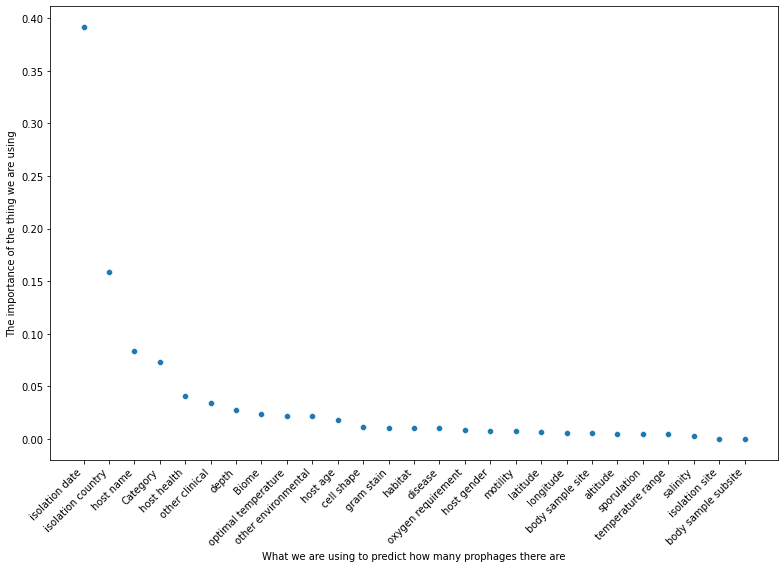

In [24]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(11, 8))
ax = sns.scatterplot(x='feature_nu', y='importance', data=impdf, ax=ax)
plt.xticks(rotation=45,  horizontalalignment='right')
ax.set_xlabel("What we are using to predict how many prophages there are")
ax.set_ylabel("The importance of the thing we are using")
plt.tight_layout()

plt.savefig(f"images/rf_importance.png")
plt.savefig(f"images/rf_importance.svg")

In [25]:
printmd(f"**Fig. S\*\***. Variable importance plot for each of the {impdf.shape[0]} features tested by the random forest")

<span style='color:black'>**Fig. S\*\***. Variable importance plot for each of the 27 features tested by the random forest</span>

In [26]:
printmd("**Random Forest output**", "blue")
printmd(f"There were {rf.n_features_} _features_ (columns in the dataframe), and {rf.n_classes_} _classes_ (unique categories)")
printmd(f"The OOB error was {rf.oob_score_}")

<span style='color:blue'>**Random Forest output**</span>

<span style='color:black'>There were 27 _features_ (columns in the dataframe), and 33 _classes_ (unique categories)</span>

<span style='color:black'>The OOB error was 0.16439812480924015</span>

### Confusion matrix is not what you want

This is the number of times prophage predictions are wrong. e.g. how often do we predict 2 prophages but really it is 3 prophages.

Text(33.0, 0.5, 'Actual number of prophages')

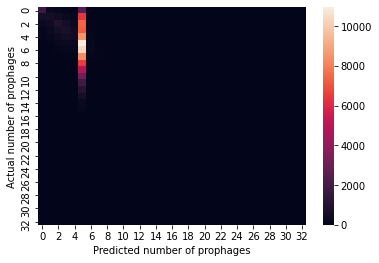

In [27]:
ax = sns.heatmap(metrics.confusion_matrix(y_test, y_pred, labels=clf.classes_))
ax.set_xlabel('Predicted number of prophages')
ax.set_ylabel('Actual number of prophages')

# Exploring the data

Lets take a look at some of these important things.

## Isolation date of the phage

Note that above we do a lot of work to create the `isolation_date` field, which is now the year of isolation as a decimal so that it plots out nicely! 


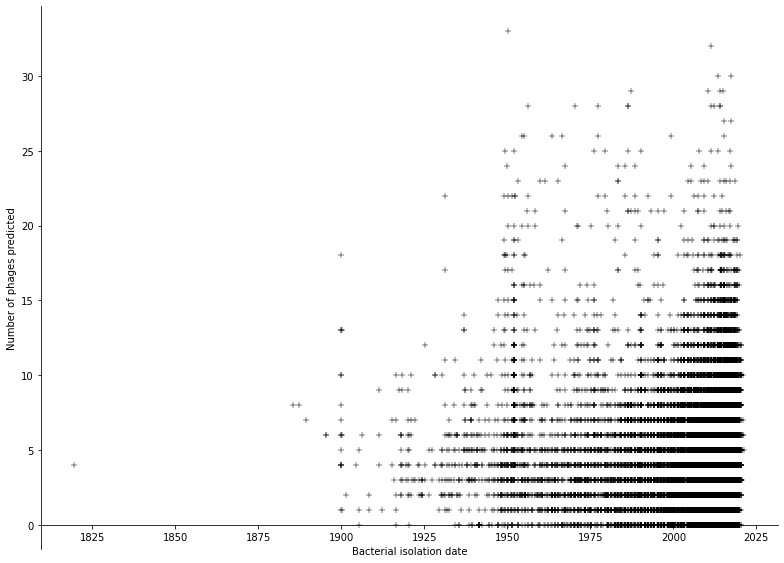

In [28]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(11, 8))
ax = sns.scatterplot(x='isolation_date', y='Kept', data=phagemeta[phagemeta['isolation_date'].notnull()], ax=ax, marker='+', color='k')
ax.set_ylabel("Number of phages predicted")
ax.set_xlabel("Bacterial isolation date")
#ax.axhline(y=0, color='k')
ax.spines['bottom'].set_position('zero')
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
plt.tight_layout()

fig.savefig(f"images/phages_vs_ya.png")
fig.savefig(f"images/phages_vs_ya.svg")

In [29]:
print(f"Fig. *** Number of prophages per genome for each of the {phagemeta[phagemeta['isolation_date'].notnull()].shape[0]:,} genomes for which the isolation date is known")

Fig. *** Number of prophages per genome for each of the 63,822 genomes for which the isolation date is known


<ipython-input-30-8481a117eccf>:9: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()


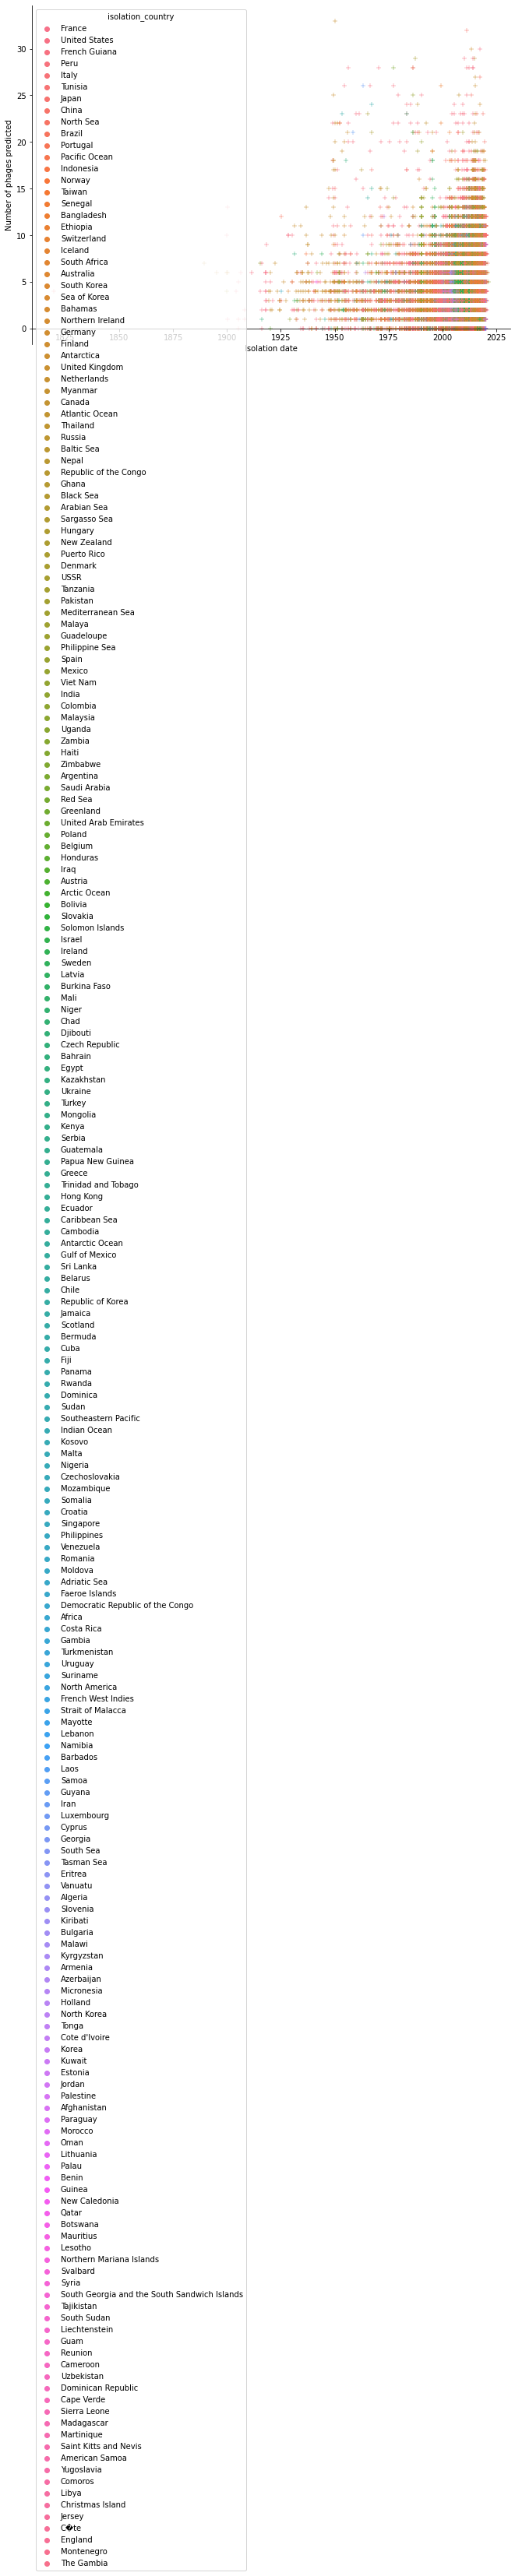

In [30]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(11, 8))
ax = sns.scatterplot(x='isolation_date', y='Kept', data=phagemeta[phagemeta['isolation_date'] != -1], hue=phagemeta['isolation_country'], ax=ax, marker='+', color='k')
ax.set_ylabel("Number of phages predicted")
ax.set_xlabel("Isolation date")
#ax.axhline(y=0, color='k')
ax.spines['bottom'].set_position('zero')
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
plt.tight_layout()


## Isolation Country

Here we look at isolation country. Note that earlier we fixed a few countries (e.g. USA -> United States), etc.

Note that we have kept true zero counts: these are genomes for which we have no prophages isolated

In [31]:
phagemeta[(phagemeta['isolation_country'] == 'United States') & (phagemeta['Kept'] == 0)][['assembly_accession', 'Kept']]

,assembly_accession,Kept
22,GCA_000020305.1,0.0
78,GCA_000021505.1,0.0
86,GCA_000021685.1,0.0
116,GCA_000022525.1,0.0
133,GCA_000022945.1,0.0
...,...,...
388259,GCA_902728245.1,0.0
388260,GCA_902728255.1,0.0
388549,GCA_902859695.1,0.0
388552,GCA_902859735.1,0.0


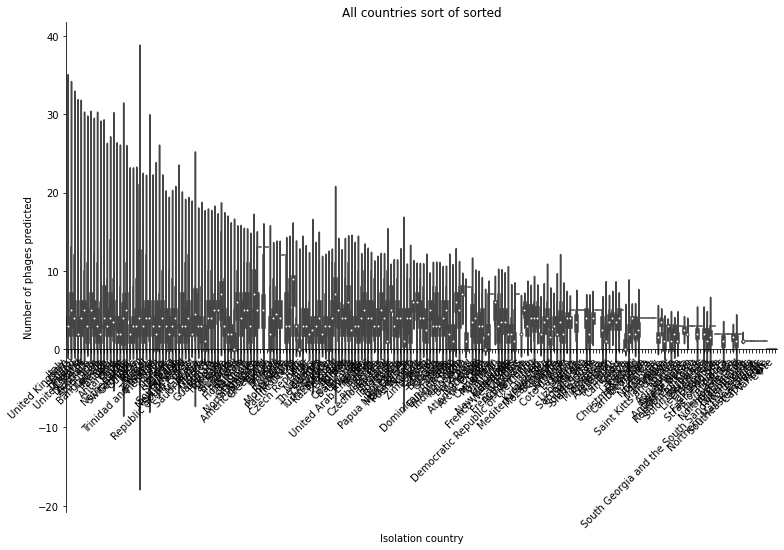

In [32]:
tmp = phagemeta[phagemeta['isolation_country'].notnull()].sort_values('Kept', ascending=False)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(11, 8))
ax = sns.violinplot(x='isolation_country', y='Kept', data=tmp, ax=ax)
ax.set_ylabel("Number of phages predicted")
ax.set_xlabel("Isolation country")
#ax.axhline(y=0, color='k')
ax.spines['bottom'].set_position('zero')
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
plt.xticks(rotation=45,  horizontalalignment='right')
ax.set_title('All countries sort of sorted')
plt.tight_layout()

fig.savefig(f"images/phages_vs_country_all.png")
fig.savefig(f"images/phages_vs_country_all.svg")

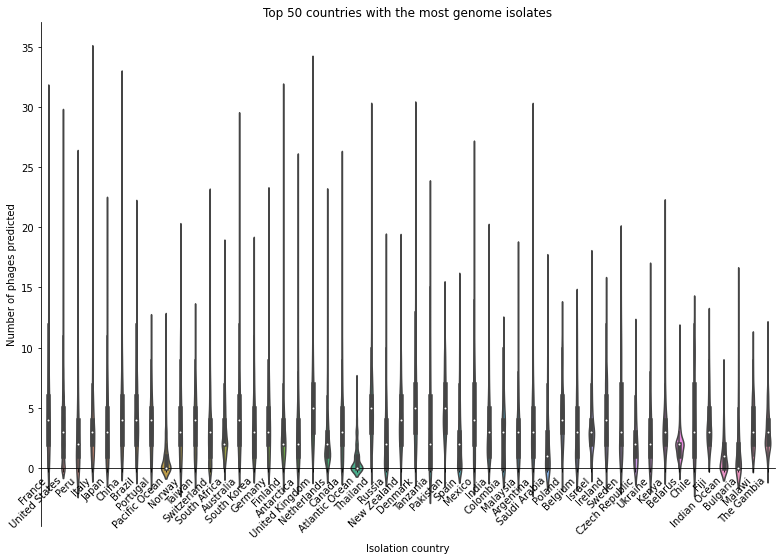

In [33]:
topnc = 50
tmp = phagemeta[phagemeta['isolation_country'].isin(phagemeta.groupby('isolation_country').count().sort_values('assembly_accession', ascending=False).head(topnc).index)]
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(11, 8))
ax = sns.violinplot(x='isolation_country', y='Kept', data=tmp, ax=ax)
ax.set_ylabel("Number of phages predicted")
ax.set_xlabel("Isolation country")
ax.spines['bottom'].set_position('zero')
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.set_title(f'Top {topnc} countries with the most genome isolates')
plt.xticks(rotation=45,  horizontalalignment='right')
plt.tight_layout()

fig.savefig(f"images/phages_vs_country_top.png")
fig.savefig(f"images/phages_vs_country_top.svg")

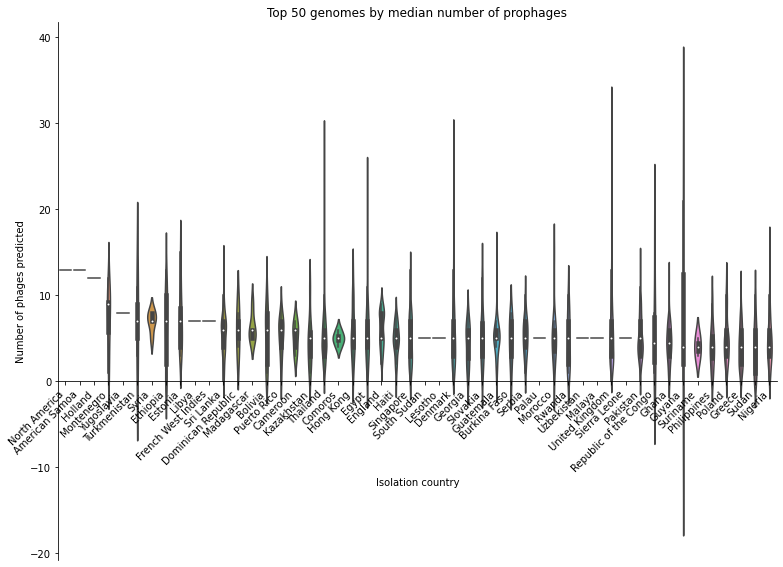

In [34]:
topnc = 50
tmp = phagemeta[phagemeta['isolation_country'].notnull()].sort_values('Kept', ascending=False)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(11, 8))
sortedorder = phagemeta.groupby('isolation_country')["Kept"].median().sort_values(ascending=False).index[0:topnc]
ax = sns.violinplot(x='isolation_country', y='Kept', data=tmp, ax=ax, order=sortedorder)
ax.set_ylabel("Number of phages predicted")
ax.set_xlabel("Isolation country")
#ax.axhline(y=0, color='k')
ax.spines['bottom'].set_position('zero')
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.set_title(f'Top {topnc} genomes by median number of prophages')
plt.xticks(rotation=45,  horizontalalignment='right')
plt.tight_layout()

fig.savefig(f"images/phages_vs_country_{topnc}_median.png")
fig.savefig(f"images/phages_vs_country_{topnc}_median.svg")

In [35]:
topnc=50
phagemeta.groupby('isolation_country')["Kept"].median().sort_values(ascending=False).index[0:topnc]

Index(['North America', 'American Samoa', 'Holland', 'Montenegro',
       'Yugoslavia', 'Turkmenistan', 'Syria', 'Ethiopia', 'Estonia', 'Libya',
       'French West Indies', 'Sri Lanka', 'Dominican Republic', 'Madagascar',
       'Bolivia', 'Puerto Rico', 'Cameroon', 'Kazakhstan', 'Thailand',
       'Comoros', 'Hong Kong', 'Egypt', 'England', 'Haiti', 'Singapore',
       'South Sudan', 'Lesotho', 'Denmark', 'Georgia', 'Slovakia', 'Guatemala',
       'Burkina Faso', 'Serbia', 'Palau', 'Morocco', 'Rwanda', 'Uzbekistan',
       'Malaya', 'United Kingdom', 'Sierra Leone', 'Pakistan',
       'Republic of the Congo', 'Ghana', 'Guyana', 'Suriname', 'Philippines',
       'Poland', 'Greece', 'Sudan', 'Nigeria'],
      dtype='object', name='isolation_country')

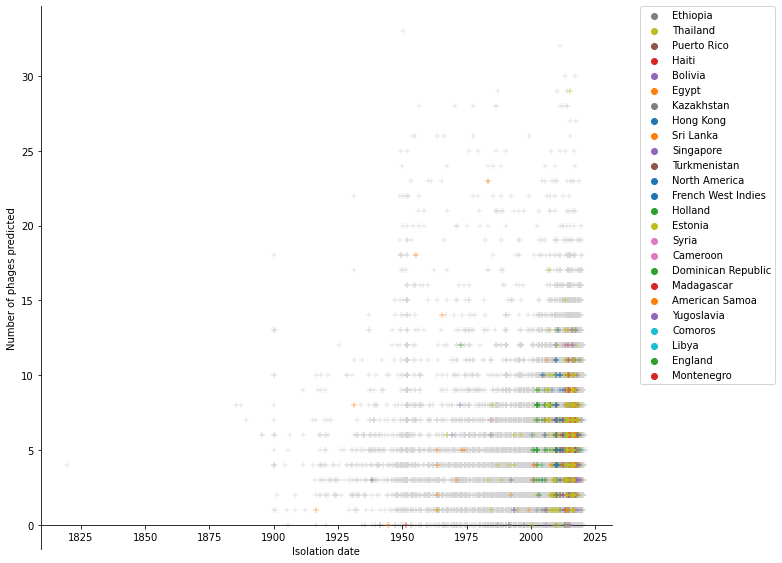

In [36]:
topnc=25
wanted = phagemeta.groupby('isolation_country')["Kept"].median().sort_values(ascending=False).index[0:topnc]
palette = dict(zip(wanted, sns.color_palette(n_colors=len(wanted))))
palette.update({"Other": "lightgrey"})

# we want other to be light grey and in the background
tmpother = phagemeta[~phagemeta['isolation_country'].isin(wanted)]
# we want these to be coloured and on top
tmpwant = phagemeta[phagemeta['isolation_country'].isin(wanted)]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(11, 8))

ax = sns.scatterplot(x='isolation_date', y='Kept', data=tmpother[tmpother['isolation_date'] != -1], color='lightgrey', ax=ax, marker='+', zorder=-5)
ax = sns.scatterplot(x='isolation_date', y='Kept', data=tmpwant[tmpwant['isolation_date'] != -1], hue=tmpwant['isolation_country'], ax=ax, marker='+', palette=palette, zorder=10)

ax.set_ylabel("Number of phages predicted")
ax.set_xlabel("Isolation date")
ax.spines['bottom'].set_position('zero')
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
l = plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.tight_layout()

fig.savefig(f"images/top_{topnc}_median_genomes_by_year.png")
fig.savefig(f"images/top_{topnc}_median_genomes_by_year.svg")

In [37]:
phagemeta.groupby('isolation_country')["Kept"].std().sort_values(ascending=False)

isolation_country
Guyana                   11.150486
Cuba                      6.746192
Nepal                     6.654751
Republic of the Congo     5.913262
Turkmenistan              5.656854
                           ...    
Strait of Malacca              NaN
Tasman Sea                     NaN
Uzbekistan                     NaN
Yugoslavia                     NaN
Zambia                         NaN
Name: Kept, Length: 218, dtype: float64

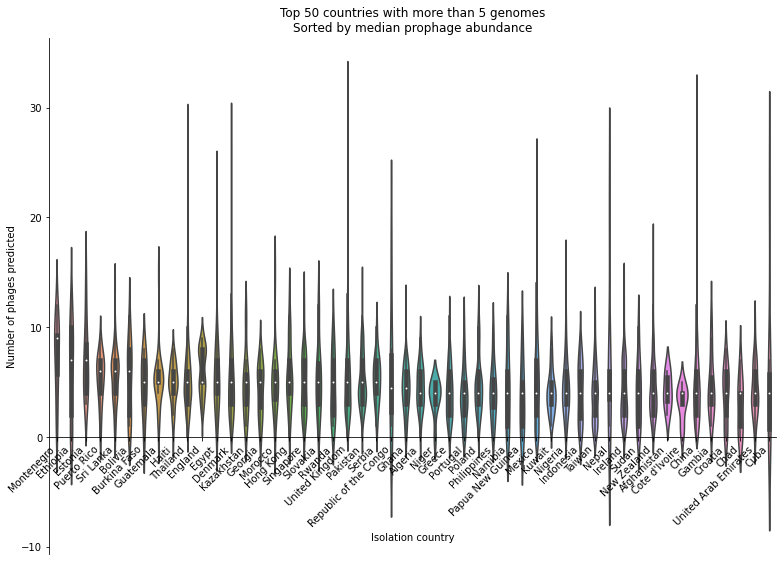

In [38]:
topnc = 50
genomen = 5 
tmpc = pd.DataFrame(phagemeta.groupby('isolation_country').count()['assembly_accession'] > genomen)
tmpc[tmpc['assembly_accession']].index
tmp = phagemeta[phagemeta['isolation_country'].isin(tmpc[tmpc['assembly_accession']].index)]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(11, 8))
sortedorder = tmp.groupby('isolation_country')["Kept"].median().sort_values(ascending=False).index[0:topnc]
ax = sns.violinplot(x='isolation_country', y='Kept', data=tmp, ax=ax, order=sortedorder)
ax.set_ylabel("Number of phages predicted")
ax.set_xlabel("Isolation country")
#ax.axhline(y=0, color='k')
ax.spines['bottom'].set_position('zero')
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.set_title(f'Top {topnc} countries with more than {genomen} genomes\nSorted by median prophage abundance')
plt.xticks(rotation=45,  horizontalalignment='right')
plt.tight_layout()

fig.savefig(f"images/phages_vs_country_{topnc}_genomes_{genomen}_phages_median.png")
fig.savefig(f"images/phages_vs_country_{topnc}_genomes_{genomen}_phages_median.svg")

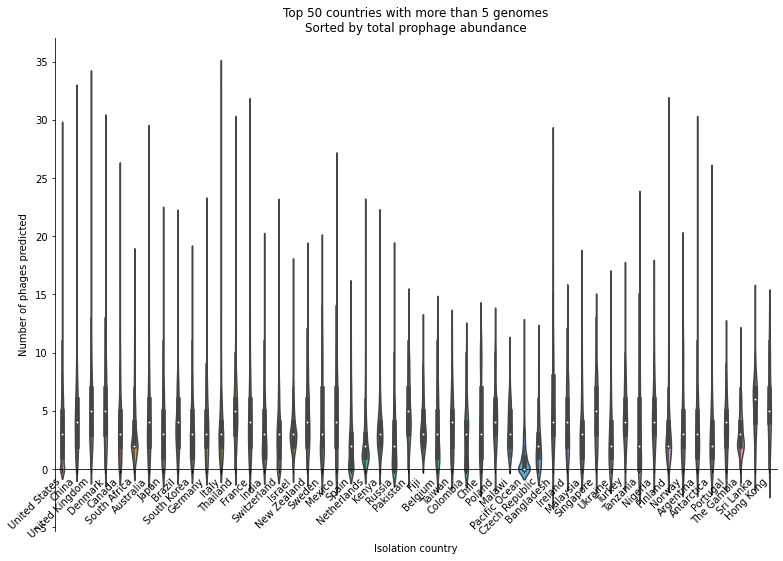

In [39]:
topnc = 50
genomen = 5 
tmpc = pd.DataFrame(phagemeta.groupby('isolation_country').count()['assembly_accession'] > genomen)
tmpc[tmpc['assembly_accession']].index
tmp = phagemeta[phagemeta['isolation_country'].isin(tmpc[tmpc['assembly_accession']].index)]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(11, 8))
sortedorder = tmp.groupby('isolation_country')["Kept"].sum().sort_values(ascending=False).index[0:topnc]
ax = sns.violinplot(x='isolation_country', y='Kept', data=tmp, ax=ax, order=sortedorder)
ax.set_ylabel("Number of phages predicted")
ax.set_xlabel("Isolation country")
#ax.axhline(y=0, color='k')
ax.spines['bottom'].set_position('zero')
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.set_title(f'Top {topnc} countries with more than {genomen} genomes\nSorted by total prophage abundance')
plt.xticks(rotation=45,  horizontalalignment='right')
plt.tight_layout()

fig.savefig(f"images/phages_vs_country_{topnc}_genomes_{genomen}_phages_sum.png")
fig.savefig(f"images/phages_vs_country_{topnc}_genomes_{genomen}_phages_sum.svg")

## Host Name

This is generally where the bacteria was isolated from

In [40]:
pd.unique(phagemeta[phagemeta['host_name'].notnull()]['host_name'])

array(['Human, Homo sapiens', 'Palo de hoz, Machaerium lunatum',
       'Cow, Bos taurus', ..., 'Trichechus manatus', 'Pica pica',
       'QI0055'], dtype=object)

In [41]:
phagemeta.groupby('host_name').count().sort_values('assembly_accession',ascending=False).head(50)

,assembly_accession,isolation_site,isolation_country,latitude,longitude,altitude,depth,other_environmental,host_gender,host_age,...,Biome,assembly_name,Genome length,Contigs,Phage Contigs,Total Predicted Prophages,Kept,No phage genes,Not enough genes,bp prophage
host_name,,,,,,,,,,,,,,,,,,,,,
"Human, Homo sapiens",30486,128,28016,2832,2831,32,8,502,2780,2579,...,15064,30486,30486,30486,30486,30486,30486,30486,30486,30486
"Cow, Bos taurus",1705,0,1597,0,0,5,19,38,129,7,...,815,1705,1705,1705,1705,1705,1705,1705,1705,1705
"Chicken, Gallus gallus",883,0,751,0,0,0,0,109,0,1,...,430,883,883,883,883,883,883,883,883,883
"Pig, Sus scrofa",594,0,537,0,0,3,0,13,3,3,...,363,594,594,594,594,594,594,594,594,594
San Clemente Island Goat,497,0,497,0,0,0,0,0,0,0,...,0,497,497,497,497,497,497,497,497,497
"Horse, Equus caballus",311,0,289,0,0,0,0,1,1,3,...,230,311,311,311,311,311,311,311,311,311
"Dog, Canis lupus familiaris",299,0,273,0,0,0,0,4,9,13,...,132,299,299,299,299,299,299,299,299,299
Homo sapiens,287,0,151,0,0,0,0,0,7,8,...,0,287,287,287,287,287,287,287,287,287
"Mouse, Mus musculus",222,0,205,0,0,0,0,43,3,28,...,86,222,222,222,222,222,222,222,222,222


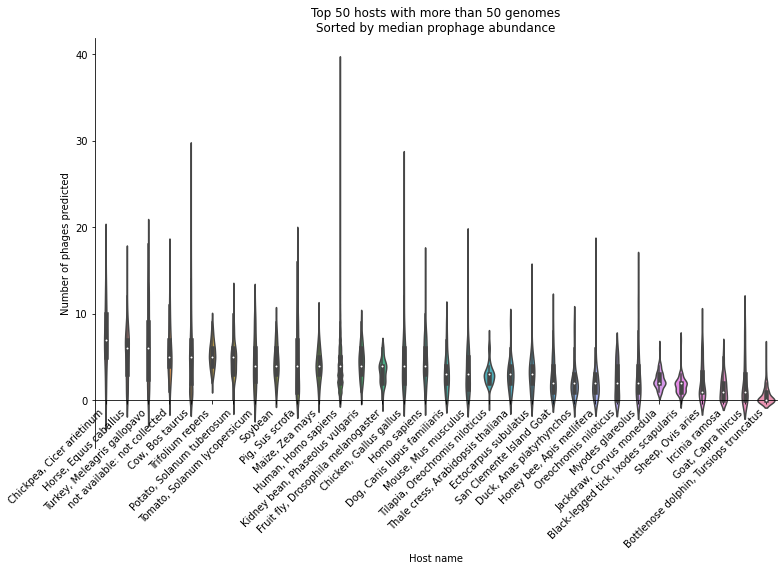

In [42]:
topnc = 50
hostn = 50 
tmpc = pd.DataFrame(phagemeta.groupby('host_name').count()['assembly_accession'] > hostn)
tmp = phagemeta[phagemeta['host_name'].isin(tmpc[tmpc['assembly_accession']].index)]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(11, 8))
sortedorder = tmp.groupby('host_name')["Kept"].median().sort_values(ascending=False).index[0:topnc]
ax = sns.violinplot(x='host_name', y='Kept', data=tmp, ax=ax, order=sortedorder)
ax.set_ylabel("Number of phages predicted")
ax.set_xlabel("Host name")
#ax.axhline(y=0, color='k')
ax.spines['bottom'].set_position('zero')
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.set_title(f'Top {topnc} hosts with more than {hostn} genomes\nSorted by median prophage abundance')
plt.xticks(rotation=45,  horizontalalignment='right')
plt.tight_layout()

fig.savefig(f"images/phages_vs_host_{topnc}_genomes_{genomen}_phages_median.png")
fig.savefig(f"images/phages_vs_host_{topnc}_genomes_{genomen}_phages_median.svg")

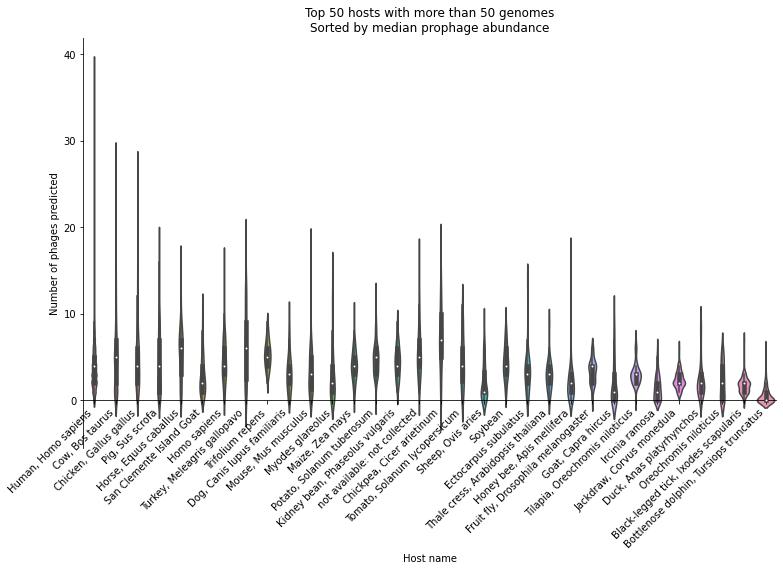

In [43]:
topnc = 50
hostn = 50 
tmpc = pd.DataFrame(phagemeta.groupby('host_name').count()['assembly_accession'] > hostn)
tmp = phagemeta[phagemeta['host_name'].isin(tmpc[tmpc['assembly_accession']].index)]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(11, 8))
sortedorder = tmp.groupby('host_name')["Kept"].sum().sort_values(ascending=False).index[0:topnc]
ax = sns.violinplot(x='host_name', y='Kept', data=tmp, ax=ax, order=sortedorder)
ax.set_ylabel("Number of phages predicted")
ax.set_xlabel("Host name")
#ax.axhline(y=0, color='k')
ax.spines['bottom'].set_position('zero')
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.set_title(f'Top {topnc} hosts with more than {hostn} genomes\nSorted by median prophage abundance')
plt.xticks(rotation=45,  horizontalalignment='right')
plt.tight_layout()

fig.savefig(f"images/phages_vs_host_{topnc}_genomes_{genomen}_phages_median.png")
fig.savefig(f"images/phages_vs_host_{topnc}_genomes_{genomen}_phages_median.svg")

In [44]:
phagemeta[phagemeta['host_name'] == 'Portulaca grandiflora']

,assembly_accession,isolation_site,isolation_country,latitude,longitude,altitude,depth,other_environmental,host_name,host_gender,...,Biome,assembly_name,Genome length,Contigs,Phage Contigs,Total Predicted Prophages,Kept,No phage genes,Not enough genes,bp prophage


## Isolation Site

In [45]:
isx_train, isx_test, isy_train, isy_test = train_test_split(pmenc['isolation_site'], phagemeta.Kept.values.ravel())
clf = RandomForestClassifier(random_state=42, n_estimators=1000, bootstrap=True, n_jobs=-1, oob_score=True)
isrf = clf.fit(isx_train.ravel().reshape(-1,1), isy_train)
isy_pred=clf.predict(isx_test.ravel().reshape(-1,1))
print("Accuracy:",metrics.accuracy_score(isy_test, isy_pred))
f1base = metrics.f1_score(isy_test, isy_pred, average='weighted')
print("f1: ", f1base)

Accuracy: 0.12602880658436214
f1:  0.028418357169404707


### the goal!!

Make a plot of importance of each country against {mean, median, stdev, total number} of prophages to understand what is important in driving countries.

See the logo analysis!